# Cry vs Non-Cry Audio EDA Notebook

This notebook performs an end-to-end exploratory data analysis (EDA) of an audio dataset containing Cry (with subcategories) and Non-Cry classes. It covers dataset overview, metadata (duration, sample rate), feature extraction (MFCCs, Chroma, Spectral Contrast, ZCR, Pitch), visual comparisons, preprocessing, dimensionality reduction, and statistical testing.

Notes:
- The dataset is expected under `Dataset/` at the project root.
- Cry subcategories are assumed to be directories under `Dataset/cry-categorized/`.
- Non-Cry files are assumed to be under `Dataset/non-cry/` (flat or nested). Adjust paths if your layout differs.


In [6]:
# 1. Setup and Imports
import os, sys, json, math, itertools, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Audio/libs
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from scipy.stats import ttest_ind, f_oneway, levene

# ML/Stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm

warnings.filterwarnings("ignore")

# Plot style and random seed
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)
np.random.seed(42)

# Global config
CONFIG = {
    "root_dir": str(Path.cwd() / "../Dataset"),
    "cry_dirname": "cry-categorized",
    "noncry_dirname": "non-cry",
    "allowed_exts": [".wav", ".mp3", ".flac", ".m4a", ".ogg", ".3gp", ".aac"],  # <-- changed to list
    "target_sr": 22050,
    "target_format": "wav",              # intended standardized format
    "target_duration_sec": 5.0,           # optional fixed-length target
    "n_mfcc": 13,
    "standardized_root": str(Path.cwd() / "../Dataset/Dataset_standardized")
}

print(json.dumps(CONFIG, indent=2))


# Helper for pretty printing counts
def print_counts(title, series):
    print(f"\n{title}")
    print(series.sort_values(ascending=False))


{
  "root_dir": "c:\\Users\\mkhan\\Documents\\Projects\\Niha2\\Notebook\\..\\Dataset",
  "cry_dirname": "cry-categorized",
  "noncry_dirname": "non-cry",
  "allowed_exts": [
    ".wav",
    ".mp3",
    ".flac",
    ".m4a",
    ".ogg",
    ".3gp",
    ".aac"
  ],
  "target_sr": 22050,
  "target_format": "wav",
  "target_duration_sec": 5.0,
  "n_mfcc": 13,
  "standardized_root": "c:\\Users\\mkhan\\Documents\\Projects\\Niha2\\Notebook\\..\\Dataset\\Dataset_standardized"
}


## 2. Load Dataset and Inspect Folder Structure

The dataset is expected at `Dataset/` with two main parts:
- `cry-categorized/` containing subfolders per cry type
- `non-cry/` containing non-cry audio files (flat or nested)

This section validates existence and prints a compact tree view.

In [7]:
# Validate directories and print a compact tree
root = Path(CONFIG["root_dir"]).resolve()
cry_root = root / CONFIG["cry_dirname"]
noncry_root = root / CONFIG["noncry_dirname"]

print("Root:", root)
assert root.exists(), f"Root dataset dir not found: {root}"
print("Cry root:", cry_root)
print("Non-Cry root:", noncry_root)

if not cry_root.exists():
    warnings.warn(f"Expected cry directory missing: {cry_root}")
if not noncry_root.exists():
    warnings.warn(f"Expected non-cry directory missing: {noncry_root}")

# Compact tree (depth <= 2)
def print_tree(base: Path, max_depth: int = 2):
    if not base.exists():
        print(f"[Missing] {base}")
        return
    print(f"\nTree for: {base}")
    for dirpath, dirnames, filenames in os.walk(base):
        rel = Path(dirpath).relative_to(base)
        depth = len(rel.parts)
        if depth > max_depth:
            continue
        indent = "  " * depth
        print(f"{indent}{rel if rel != Path('.') else base.name}/")
        # Show up to 5 files
        for fn in sorted(filenames)[:5]:
            print(f"{indent}  {fn}")

print_tree(cry_root, max_depth=2)
print_tree(noncry_root, max_depth=2)

# Count files per top-level folder
cry_counts = {}
if cry_root.exists():
    for sub in sorted([p for p in cry_root.iterdir() if p.is_dir()]):
        n = sum(1 for _ in sub.rglob("*") if _.is_file())
        cry_counts[sub.name] = n
cry_counts = pd.Series(cry_counts)
if not cry_counts.empty:
    print_counts("Cry subfolder file counts", cry_counts)

noncry_count = 0
if noncry_root.exists():
    noncry_count = sum(1 for _ in noncry_root.rglob("*") if _.is_file())
print(f"\nNon-Cry total files: {noncry_count}")

# Helper to map labels

def get_labels(path: Path):
    path = Path(path)
    if cry_root in path.parents:
        subcat = path.parent.name  # immediate subfolder under cry-categorized
        return "Cry", subcat
    elif noncry_root in path.parents or path.parent == noncry_root:
        return "Non-Cry", "None"
    else:
        # Try heuristic: if under cry root name appears in parts
        parts = {p.name for p in path.parents}
        if CONFIG["cry_dirname"] in parts:
            return "Cry", path.parent.name
        if CONFIG["noncry_dirname"] in parts:
            return "Non-Cry", "None"
        return "Unknown", "Unknown"


Root: C:\Users\mkhan\Documents\Projects\Niha2\Dataset
Cry root: C:\Users\mkhan\Documents\Projects\Niha2\Dataset\cry-categorized
Non-Cry root: C:\Users\mkhan\Documents\Projects\Niha2\Dataset\non-cry

Tree for: C:\Users\mkhan\Documents\Projects\Niha2\Dataset\cry-categorized
cry-categorized/
  belly pain/
    357c.wav
    358c.wav
    359c.wav
    360c.wav
    361c.wav
  burping/
    466c.wav
    467c.wav
    468c.wav
    469c.wav
    470c.wav
  cold_hot/
    100c.wav
    101c.wav
    102c.wav
    103c.wav
    104c.wav
  discomfort/
    10A40438-09AA-4A21-83B4-8119F03F7A11-1430925142-1.0-f-26-dc.wav
    11417AC2-DCC9-48CD-8177-CA8665E51B2F-1436881512-1.1-m-48-dc.wav
    124c.wav
    125c.wav
    126c.wav
  hungry/
    02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav
    02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav
    035c6b30-a145-42b9-8d0f-445cd9003d2c-1435948197257-1.7-m-04-hu.wav
    03abcb8f-400a-47d8-ad82-7e4586cc06be-1431864192133-1.7-f-48-hu

## 3. Enumerate Audio Files by Category/Subcategory

We recursively collect files with allowed extensions and build a DataFrame with labels and metadata.

In [8]:
# Gather audio files
allowed = {ext.lower() for ext in CONFIG["allowed_exts"]}
rows = []
for base in [cry_root, noncry_root]:
    if not base.exists():
        continue
    for p in base.rglob("*"):
        if p.is_file():
            ext = p.suffix.lower()
            if ext in allowed:
                category, subcat = get_labels(p)
                rows.append({
                    "path": str(p.resolve()),
                    "rel_path": str(p.resolve().relative_to(root)),
                    "filename": p.name,
                    "ext": ext,
                    "category": category,
                    "subcategory": subcat if category == "Cry" else "None",
                })

files_df = pd.DataFrame(rows)
print("Total audio files found:", len(files_df))
files_df.head(10)

Total audio files found: 1774


,path,rel_path,filename,ext,category,subcategory
0,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\357c.wav,357c.wav,.wav,Cry,belly pain
1,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\358c.wav,358c.wav,.wav,Cry,belly pain
2,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\359c.wav,359c.wav,.wav,Cry,belly pain
3,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\360c.wav,360c.wav,.wav,Cry,belly pain
4,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\361c.wav,361c.wav,.wav,Cry,belly pain
5,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\362c.wav,362c.wav,.wav,Cry,belly pain
6,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\363c.wav,363c.wav,.wav,Cry,belly pain
7,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\364c.wav,364c.wav,.wav,Cry,belly pain
8,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\365c.wav,365c.wav,.wav,Cry,belly pain
9,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,cry-categorized\belly pain\366c.wav,366c.wav,.wav,Cry,belly pain


In [9]:
# Basic sanity checks and group counts
if len(files_df) == 0:
    warnings.warn("No audio files found with allowed extensions. Check paths and extensions.")
else:
    print_counts("Counts by category", files_df["category"].value_counts())
    if (files_df["category"] == "Cry").any():
        print_counts("Counts by cry subcategory", files_df.query("category == 'Cry'")["subcategory"].value_counts())
    print_counts("Counts by extension", files_df["ext"].value_counts())



Counts by category
category
Cry        1450
Non-Cry     324
Name: count, dtype: int64

Counts by cry subcategory
subcategory
hungry        397
discomfort    142
tired         142
belly pain    133
cold_hot      130
burping       124
laugh         108
silence       108
noise         108
scared         33
lonely         25
Name: count, dtype: int64

Counts by extension
ext
.wav    1471
.ogg     224
.3gp      72
.mp3       7
Name: count, dtype: int64


## 4. Validate and Harmonize Audio File Formats

Inspect unique file extensions and outline a plan to standardize to a single target format/sample rate/channel if needed. Optionally convert to WAV PCM 16-bit mono at target sample rate into a mirrored folder structure.

In [10]:
# Inspect extensions and counts
ext_counts = files_df["ext"].value_counts()
print_counts("Extension counts", ext_counts)

# Optional conversion preview (no actual conversion by default). Set do_convert=True to create standardized copies.
do_convert = False
std_root = Path(CONFIG["standardized_root"]) / Path(CONFIG["root_dir"]).name
print("Standardized output root (if enabled):", std_root)

if do_convert:
    for _, row in tqdm(files_df.iterrows(), total=len(files_df)):
        src = Path(row["path"])
        rel = Path(row["rel_path"])  # under Dataset/
        dst = std_root / rel
        dst = dst.with_suffix("." + CONFIG["target_format"])  # enforce format
        dst.parent.mkdir(parents=True, exist_ok=True)
        try:
            y, sr = librosa.load(str(src), sr=CONFIG["target_sr"], mono=True)
            sf.write(str(dst), y, CONFIG["target_sr"], subtype='PCM_16')
        except Exception as e:
            print(f"[Convert Error] {src} -> {dst}: {e}")

# Choose a working root for subsequent loads (standardized if exists and chosen)
WORKING_ROOT = std_root if (do_convert and std_root.exists()) else root
print("Using WORKING_ROOT:", WORKING_ROOT)



Extension counts
ext
.wav    1471
.ogg     224
.3gp      72
.mp3       7
Name: count, dtype: int64
Standardized output root (if enabled): c:\Users\mkhan\Documents\Projects\Niha2\Notebook\..\Dataset\Dataset_standardized\Dataset
Using WORKING_ROOT: C:\Users\mkhan\Documents\Projects\Niha2\Dataset


## 5. Extract Durations and Visualize Distributions

We compute per-file duration and visualize histograms for Cry vs Non-Cry and per Cry subcategory.

100%|██████████| 1774/1774 [00:22<00:00, 80.54it/s] 


           count      mean       std       min       25%  50%       75%  \
category                                                                  
Cry       1450.0  6.384060  0.876219  4.150816  5.008254  6.9  7.000000   
Non-Cry    324.0  5.002247  0.005018  5.000000  5.000000  5.0  5.000998   

               max  
category            
Cry       8.730703  
Non-Cry   5.022766  


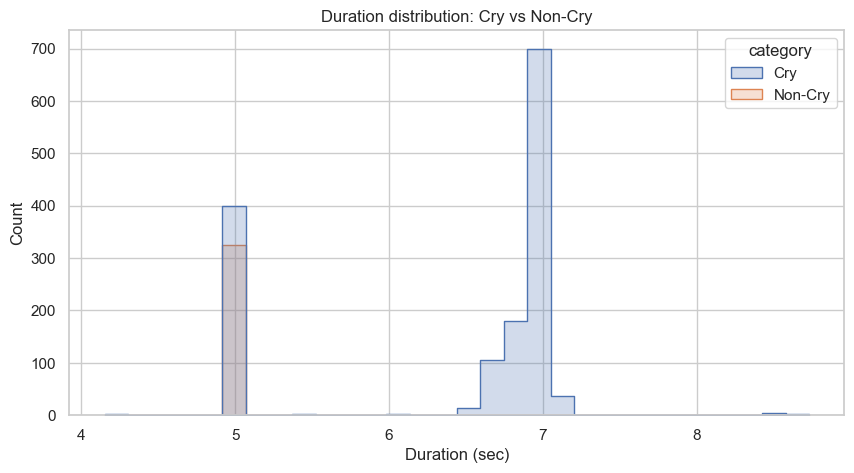

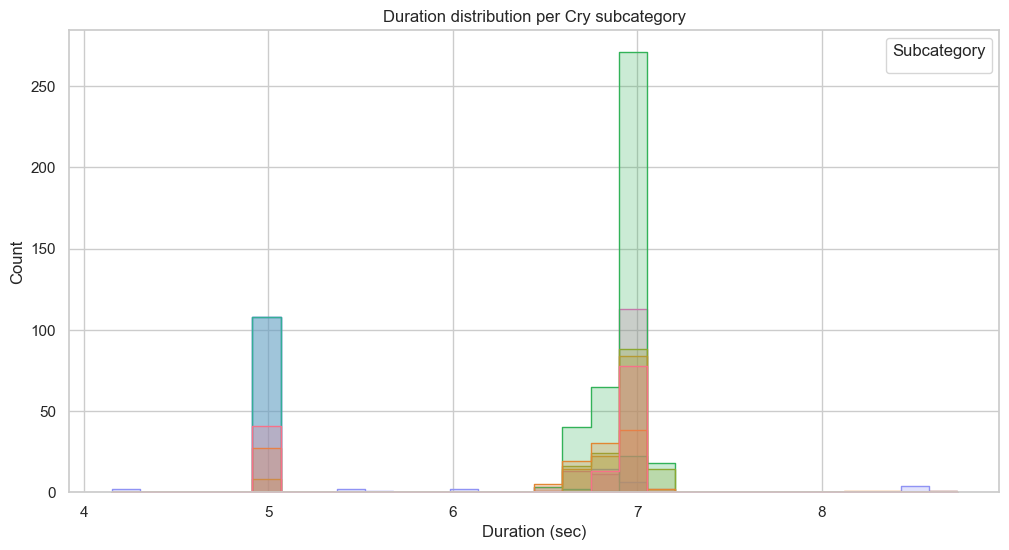

In [11]:
# Duration extraction
files_df = files_df.copy()
files_df["duration_sec"] = np.nan
files_df["samplerate"] = np.nan
files_df["meta_error"] = None

for i, row in tqdm(files_df.iterrows(), total=len(files_df)):
    p = Path(row["path"])  # original path
    try:
        info = sf.info(str(p))
        dur = info.frames / float(info.samplerate) if info.samplerate else np.nan
        files_df.at[i, "duration_sec"] = dur
        files_df.at[i, "samplerate"] = info.samplerate or np.nan
    except Exception as e:
        try:
            dur = librosa.get_duration(filename=str(p))
            files_df.at[i, "duration_sec"] = dur
        except Exception as e2:
            files_df.at[i, "meta_error"] = str(e2)

# Summary stats
summary = files_df.groupby("category")["duration_sec"].describe()
print(summary)

# Histograms: Cry vs Non-Cry
if files_df["duration_sec"].notna().any():
    g = sns.histplot(data=files_df, x="duration_sec", hue="category", bins=30, kde=False, element="step", stat="count", common_bins=True)
    g.set_title("Duration distribution: Cry vs Non-Cry")
    g.set_xlabel("Duration (sec)")
    plt.show()

    # Per Cry subcategory
    cry_df = files_df.query("category == 'Cry'")
    if not cry_df.empty:
        plt.figure(figsize=(12,6))
        sns.histplot(data=cry_df, x="duration_sec", hue="subcategory", bins=30, element="step", stat="count")
        plt.title("Duration distribution per Cry subcategory")
        plt.xlabel("Duration (sec)")
        plt.legend(loc="upper right", title="Subcategory")
        plt.show()


## 6. Inspect and Standardize Sample Rates

We extract sample rates and visualize distributions. If inconsistent, we use a target sample rate for downstream processing (resampling on load).

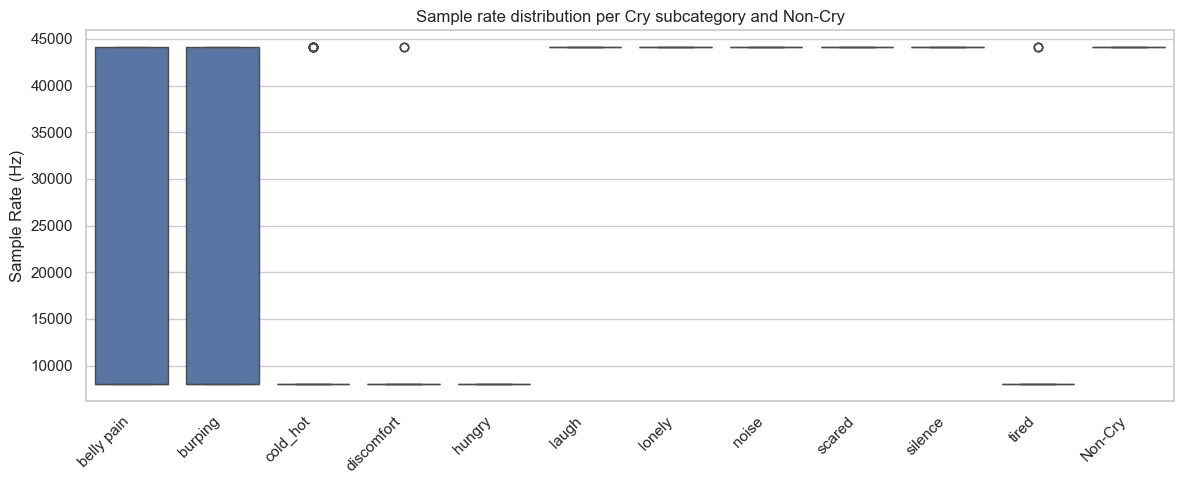

Unique sample rates: [np.float64(8000.0), np.float64(44100.0)]
Target sample rate: 22050


In [12]:
# Boxplot of sample rates
valid_sr = files_df[files_df["samplerate"].notna()].copy()
if not valid_sr.empty:
    # Single box for Non-Cry
    tmp = valid_sr.copy()
    tmp.loc[tmp["category"] == "Non-Cry", "subcategory"] = "Non-Cry"
    plt.figure(figsize=(12,5))
    sns.boxplot(data=tmp, x="subcategory", y="samplerate")
    plt.xticks(rotation=45, ha='right')
    plt.title("Sample rate distribution per Cry subcategory and Non-Cry")
    plt.ylabel("Sample Rate (Hz)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

print("Unique sample rates:", sorted(valid_sr["samplerate"].unique()))
print("Target sample rate:", CONFIG["target_sr"])


## 7. Visualize Cry Subcategory Counts and Cry vs Non-Cry

We compute counts per Cry subcategory and compare total Cry vs Non-Cry.

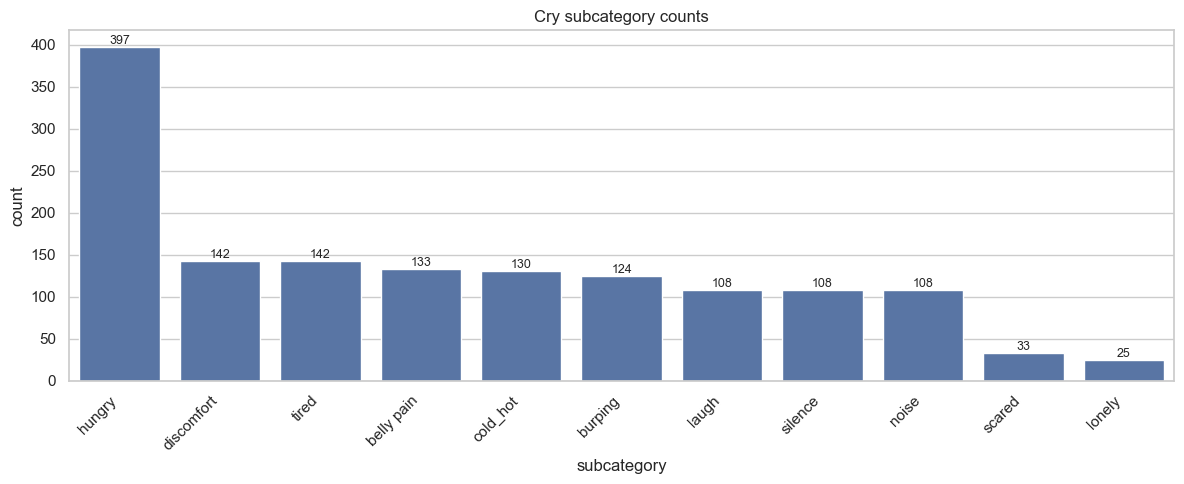

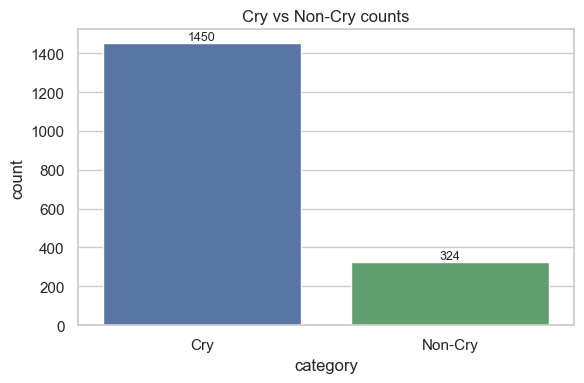

In [13]:
# Counts per subcategory and Cry vs Non-Cry
cry_df = files_df.query("category == 'Cry'")
if not cry_df.empty:
    sub_counts = cry_df["subcategory"].value_counts().reset_index()
    sub_counts.columns = ["subcategory", "count"]
    plt.figure(figsize=(12,5))
    ax = sns.barplot(data=sub_counts, x="subcategory", y="count", color="#4C72B0")
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{int(height)}", (p.get_x()+p.get_width()/2., height), ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=45, ha='right')
    plt.title("Cry subcategory counts")
    plt.tight_layout()
    plt.show()

# Cry vs Non-Cry total
cat_counts = files_df["category"].value_counts().reset_index()
cat_counts.columns = ["category", "count"]
plt.figure(figsize=(6,4))
ax = sns.barplot(data=cat_counts, x="category", y="count", palette=["#4C72B0", "#55A868"])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x()+p.get_width()/2., height), ha='center', va='bottom', fontsize=9)
plt.title("Cry vs Non-Cry counts")
plt.tight_layout()
plt.show()


## 8. Audio Feature Extraction (MFCC, Chroma, Spectral Contrast, ZCR, Pitch)

We define a robust feature extraction function and apply it to all files, building a features table that we can cache to disk.

In [14]:
# Feature extraction utilities
from typing import Dict, Any

FEATURES_CACHE = Path("Notebook/features_cache.parquet")


def pad_or_trim(y: np.ndarray, sr: int, target_sec: float) -> np.ndarray:
    if target_sec is None or target_sec <= 0:
        return y
    target_len = int(sr * target_sec)
    if len(y) > target_len:
        # center-crop
        start = (len(y) - target_len) // 2
        return y[start:start+target_len]
    elif len(y) < target_len:
        pad = target_len - len(y)
        return np.pad(y, (0, pad), mode='constant')
    return y


def extract_features_one(path: str, cfg: Dict[str, Any]) -> Dict[str, Any]:
    feats = {}
    try:
        y, sr = librosa.load(path, sr=cfg["target_sr"], mono=True)
        # optional trim
        y, _ = librosa.effects.trim(y, top_db=30)
        y = pad_or_trim(y, sr, cfg["target_duration_sec"])

        # Basic spectral features
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)[0]
        rms = librosa.feature.rms(y=y)[0]

        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=cfg["n_mfcc"])
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        # Spectral contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Pitch (f0) using yin (more robust for short clips)
        try:
            f0 = librosa.yin(y, fmin=50, fmax=800, sr=sr)
            f0 = f0[np.isfinite(f0)]
            f0_mean = float(np.nanmean(f0)) if f0.size else np.nan
            f0_median = float(np.nanmedian(f0)) if f0.size else np.nan
        except Exception:
            f0_mean = np.nan
            f0_median = np.nan

        # Aggregate stats
        feats.update({
            "zcr_mean": float(np.mean(zcr)),
            "zcr_std": float(np.std(zcr)),
            "centroid_mean": float(np.mean(centroid)),
            "centroid_std": float(np.std(centroid)),
            "bandwidth_mean": float(np.mean(bandwidth)),
            "bandwidth_std": float(np.std(bandwidth)),
            "rolloff_mean": float(np.mean(rolloff)),
            "rolloff_std": float(np.std(rolloff)),
            "rms_mean": float(np.mean(rms)),
            "rms_std": float(np.std(rms)),
            "f0_mean": f0_mean,
            "f0_median": f0_median,
        })

        # MFCC means/stds
        for i in range(mfcc.shape[0]):
            feats[f"mfcc{i+1}_mean"] = float(np.mean(mfcc[i]))
            feats[f"mfcc{i+1}_std"] = float(np.std(mfcc[i]))
        # Chroma
        for i in range(chroma.shape[0]):
            feats[f"chroma{i+1}_mean"] = float(np.mean(chroma[i]))
            feats[f"chroma{i+1}_std"] = float(np.std(chroma[i]))
        # Contrast
        for i in range(contrast.shape[0]):
            feats[f"contrast{i+1}_mean"] = float(np.mean(contrast[i]))
            feats[f"contrast{i+1}_std"] = float(np.std(contrast[i]))

    except Exception as e:
        feats["_error"] = str(e)
    return feats

# Apply extraction with caching
if FEATURES_CACHE.exists():
    print("Loading cached features from:", FEATURES_CACHE)
    features_df = pd.read_parquet(FEATURES_CACHE)
else:
    recs = []
    for i, row in tqdm(files_df.iterrows(), total=len(files_df)):
        feats = extract_features_one(row["path"], CONFIG)
        feats.update({
            "path": row["path"],
            "category": row["category"],
            "subcategory": row["subcategory"],
            "ext": row["ext"],
            "duration_sec": row.get("duration_sec", np.nan)
        })
        recs.append(feats)
    features_df = pd.DataFrame(recs)
    try:
        FEATURES_CACHE.parent.mkdir(parents=True, exist_ok=True)
        features_df.to_parquet(FEATURES_CACHE)
        print("Saved features to:", FEATURES_CACHE)
    except Exception as e:
        print("Could not save features cache:", e)

# Merge labels (ensure present)
if "category" not in features_df.columns:
    features_df = features_df.merge(files_df[["path", "category", "subcategory", "ext", "duration_sec"]], on="path", how="left")

print("Features shape:", features_df.shape)
features_df.head(5)

100%|██████████| 1774/1774 [01:46<00:00, 16.62it/s]

Could not save features cache: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
Features shape: (1774, 81)


,zcr_mean,zcr_std,centroid_mean,centroid_std,bandwidth_mean,bandwidth_std,rolloff_mean,rolloff_std,rms_mean,rms_std,...,contrast5_std,contrast6_mean,contrast6_std,contrast7_mean,contrast7_std,path,category,subcategory,ext,duration_sec
0,0.103276,0.020957,1435.099684,222.811618,956.442160,121.781747,3237.407430,287.927124,0.050311,0.071747,...,3.972133,68.061542,8.528840,18.732456,2.470098,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,Cry,belly pain,.wav,7.0
1,0.047766,0.016920,915.746599,176.550792,899.008394,134.125590,2964.902751,325.143305,0.009494,0.018119,...,1.943611,69.037499,7.267919,22.219153,2.959279,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,Cry,belly pain,.wav,7.0
2,0.124905,0.044653,1694.487286,409.084307,905.713327,141.338799,3306.393433,304.037776,0.082663,0.068369,...,5.393858,73.133519,8.498449,20.795762,2.928201,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,Cry,belly pain,.wav,7.0
3,0.082379,0.025749,1243.227610,260.950262,867.382157,149.634666,3020.580037,419.806349,0.103247,0.091583,...,3.710685,67.135631,9.130277,18.557491,2.791493,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,Cry,belly pain,.wav,7.0
4,0.137501,0.054339,1603.130669,382.873451,958.639156,170.416566,3283.514404,472.878839,0.005175,0.008629,...,2.746940,67.628372,7.935036,17.150293,2.387302,C:\Users\mkhan\Documents\Projects\Niha2\Datase...,Cry,belly pain,.wav,7.0


## 9. Time-Frequency Examples (Waveforms and Spectrograms)

We plot representative waveforms and log-mel spectrograms for Cry and Non-Cry samples.

Example: Cry -> C:\Users\mkhan\Documents\Projects\Niha2\Dataset\cry-categorized\belly pain\357c.wav


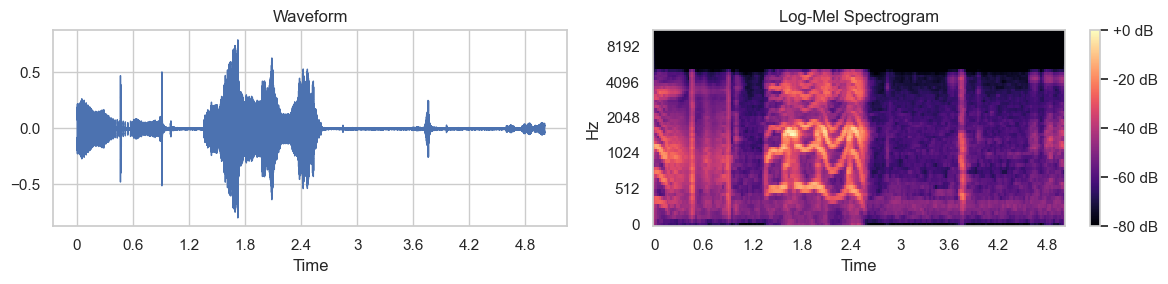

Example: Non-Cry -> C:\Users\mkhan\Documents\Projects\Niha2\Dataset\non-cry\100n.ogg


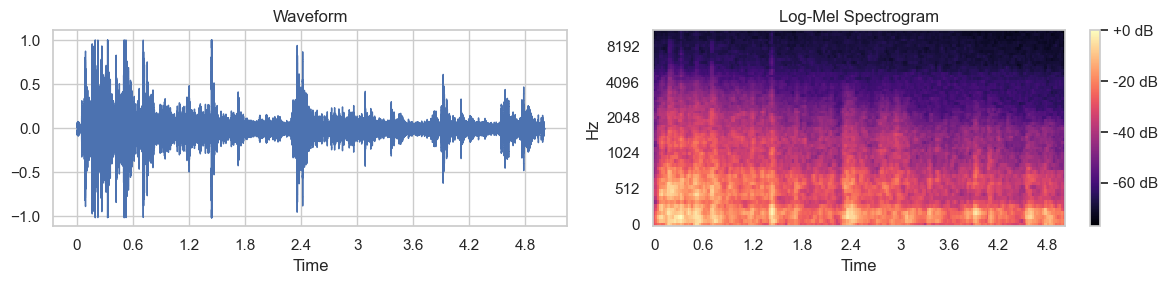

In [15]:
# Helper to plot waveform and mel spectrogram side-by-side

def plot_wave_mel(path: str, cfg=CONFIG):
    y, sr = librosa.load(path, sr=cfg["target_sr"], mono=True)
    y = pad_or_trim(y, sr, cfg["target_duration_sec"]) 

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title("Waveform")

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title("Log-Mel Spectrogram")
    fig.colorbar(img, ax=axes[1], format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

# Choose examples
cry_example = files_df.query("category == 'Cry'").head(1)
noncry_example = files_df.query("category == 'Non-Cry'").head(1)

for label, df_ex in [("Cry", cry_example), ("Non-Cry", noncry_example)]:
    if not df_ex.empty:
        p = df_ex.iloc[0]["path"]
        print(f"Example: {label} -> {p}")
        plot_wave_mel(p)


## 10. Data Quality and Preprocessing (Missing/Corrupt, Format, Length)

We summarize failures and provide optional standardization helpers for format and fixed-length audio arrays.

In [16]:
# Summarize failed metadata/feature extraction
failed_meta = files_df[files_df["meta_error"].notna() & (files_df["meta_error"] != "None")]
print("Failed metadata reads:", len(failed_meta))
if not failed_meta.empty:
    display(failed_meta[["path", "meta_error"]].head(10))

if "_error" in features_df.columns:
    failed_feat = features_df[features_df["_error"].notna()]
    print("Failed feature extraction:", len(failed_feat))
    if not failed_feat.empty:
        display(failed_feat[["path", "_error"]].head(10))

# Helper: write standardized WAV for a given path
from typing import Optional

def standardize_to_wav(src_path: str, dst_path: Optional[str] = None, cfg=CONFIG):
    src = Path(src_path)
    if dst_path is None:
        rel = Path(src_path).resolve().relative_to(root)
        dst = Path(cfg["standardized_root"]) / Path(cfg["root_dir"]).name / rel
        dst = dst.with_suffix(".wav")
    else:
        dst = Path(dst_path)
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        y, sr = librosa.load(str(src), sr=cfg["target_sr"], mono=True)
        y = pad_or_trim(y, cfg["target_sr"], cfg["target_duration_sec"])
        sf.write(str(dst), y, cfg["target_sr"], subtype='PCM_16')
        return str(dst)
    except Exception as e:
        print(f"[Standardize Error] {src} -> {dst}: {e}")
        return None

print("Example standardization helper ready. Set do_convert=True earlier to batch convert.")


Failed metadata reads: 0
Example standardization helper ready. Set do_convert=True earlier to batch convert.


## 11. Feature Distribution Comparison (Cry vs Non-Cry)

We standardize numeric features and compare distributions via KDE/box/violin plots and a limited pairplot.

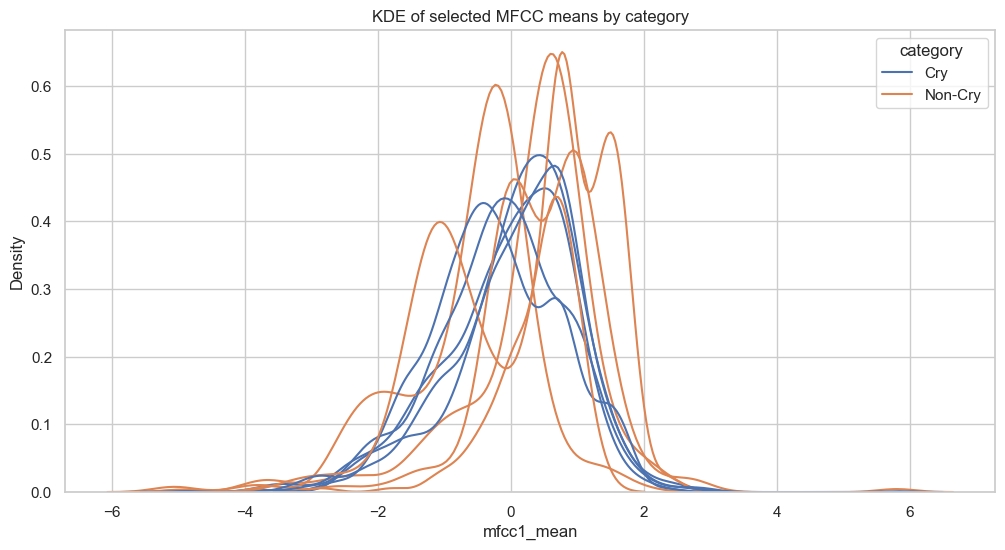

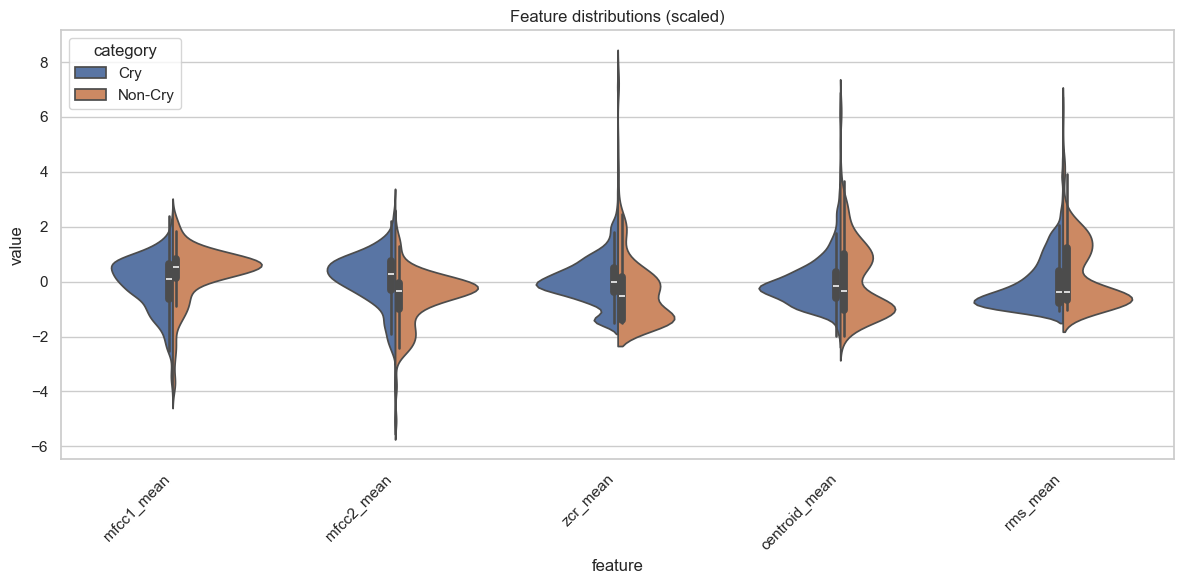

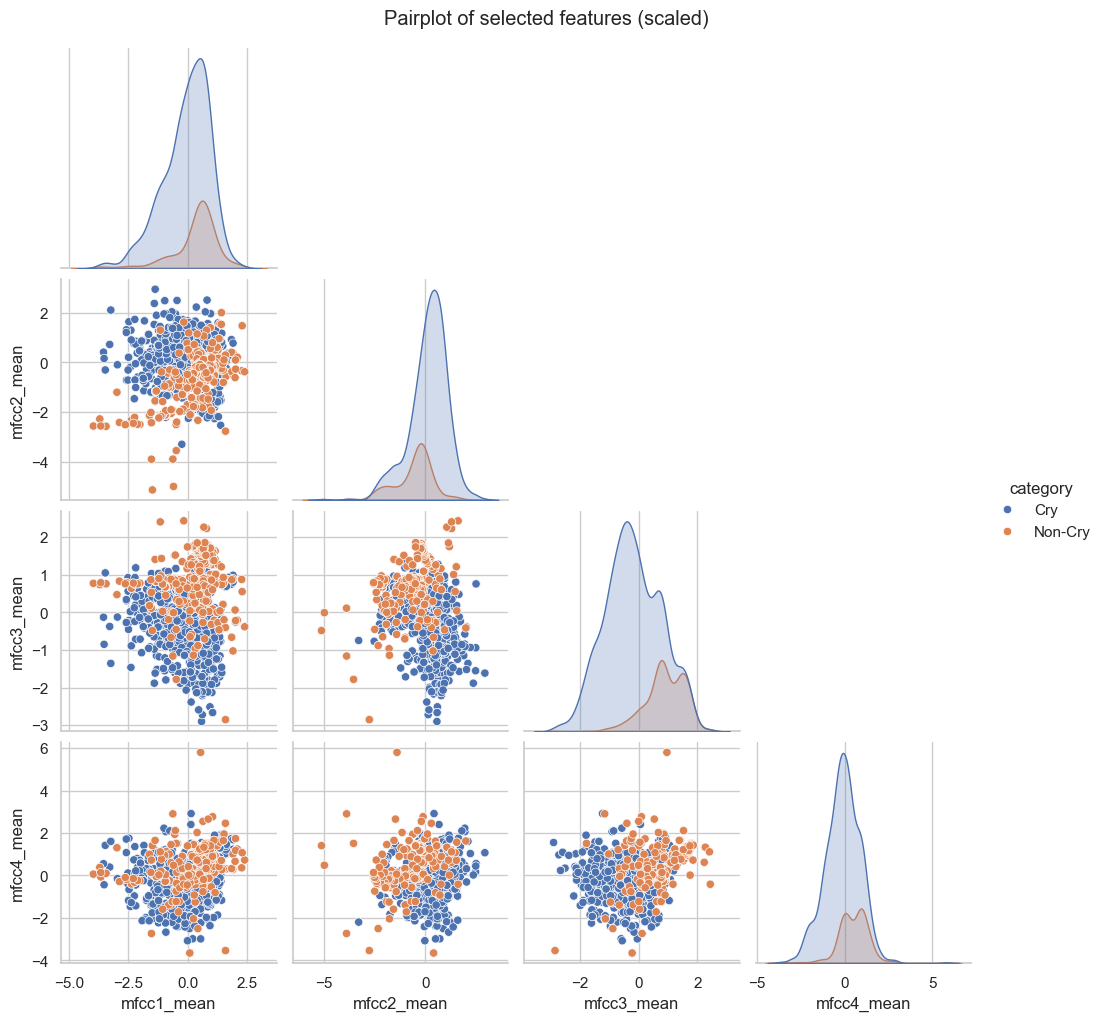

In [17]:
# Prepare features and scaling
numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
# Remove label-like numeric cols if any; keep duration
label_cols = []
X = features_df[numeric_cols].copy()
# Handle NaNs/infs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=features_df.index)

y = features_df["category"].fillna("Unknown")

# KDE for selected features
selected = [c for c in X_scaled.columns if c.startswith("mfcc") and c.endswith("_mean")][:5]
if selected:
    plt.figure(figsize=(12,6))
    for col in selected:
        sns.kdeplot(data=pd.concat([X_scaled[col], y], axis=1), x=col, hue=y.name, common_norm=False)
    plt.title("KDE of selected MFCC means by category")
    plt.show()

# Box/violin for a few key features
key_features = [
    "mfcc1_mean", "mfcc2_mean", "zcr_mean", "centroid_mean", "rms_mean"
]
key_features = [f for f in key_features if f in X_scaled.columns]
if key_features:
    df_plot = pd.concat([X_scaled[key_features], y], axis=1)
    df_plot = df_plot.melt(id_vars=["category"], var_name="feature", value_name="value")
    plt.figure(figsize=(12,6))
    sns.violinplot(data=df_plot, x="feature", y="value", hue="category", split=True)
    plt.title("Feature distributions (scaled)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Pairplot on subset (may be slow on large data)
subset_cols = selected[:4]
if len(subset_cols) >= 2:
    pp = pd.concat([X_scaled[subset_cols], y], axis=1)
    sns.pairplot(pp, hue="category", corner=True)
    plt.suptitle("Pairplot of selected features (scaled)", y=1.02)
    plt.show()


## 12. Dimensionality Reduction (PCA, t-SNE) and 2D/3D Plots

We embed scaled features with PCA and t-SNE to visualize separability between Cry and Non-Cry.

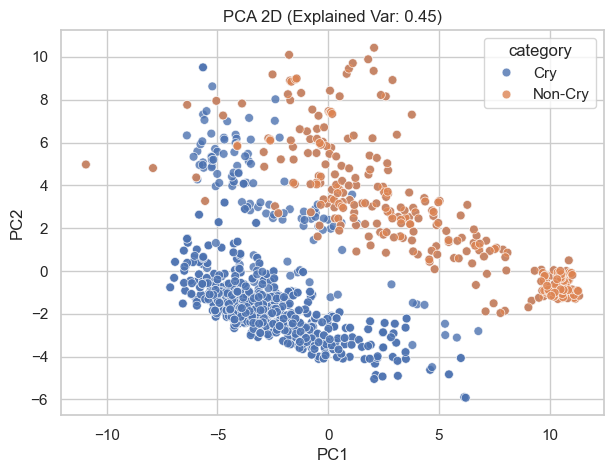

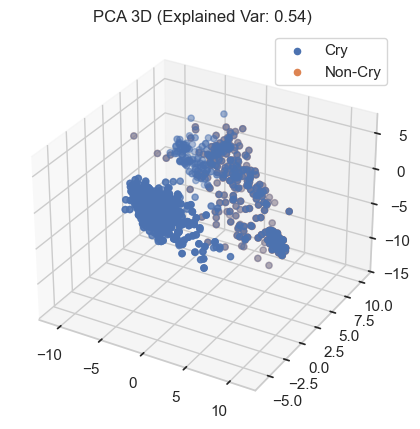

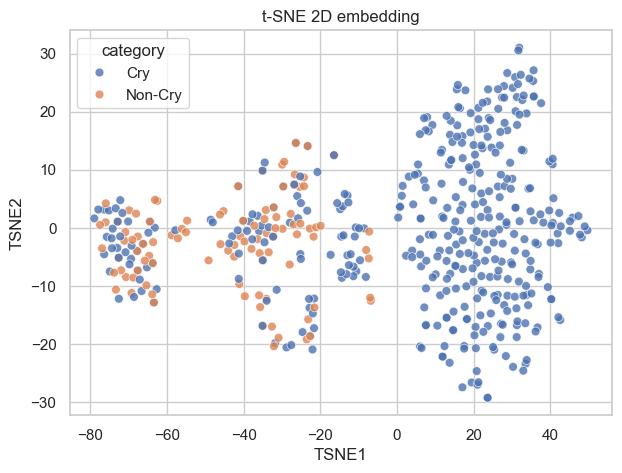

In [18]:
# PCA 2D and 3D
pca2 = PCA(n_components=2, random_state=42)
emb2 = pca2.fit_transform(X_scaled)
emb2 = pd.DataFrame(emb2, columns=["PC1", "PC2"]) 
emb2["category"] = y.values

plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=emb2, x="PC1", y="PC2", hue="category", s=40, alpha=0.8)
plt.title(f"PCA 2D (Explained Var: {pca2.explained_variance_ratio_.sum():.2f})")
plt.show()

# Optional 3D
try:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    pca3 = PCA(n_components=3, random_state=42)
    emb3 = pca3.fit_transform(X_scaled)
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    cat_to_color = {c: col for c, col in zip(sorted(y.unique()), sns.color_palette("Set2", n_colors=len(y.unique())))}
    for cat in sorted(y.unique()):
        idx = (y.values == cat)
        ax.scatter(emb3[idx,0], emb3[idx,1], emb3[idx,2], label=cat, s=20)
    ax.set_title(f"PCA 3D (Explained Var: {pca3.explained_variance_ratio_.sum():.2f})")
    ax.legend()
    plt.show()
except Exception as e:
    print("3D PCA plot skipped:", e)

# t-SNE 2D (may be slow; optionally subsample)
subset_idx = np.arange(len(X_scaled))
if len(X_scaled) > 500:
    subset_idx = np.random.choice(len(X_scaled), size=500, replace=False)
Xt = X_scaled.iloc[subset_idx]
yt = y.iloc[subset_idx]

tsne = TSNE(n_components=2, perplexity=max(5, min(30, len(Xt)//3)), learning_rate='auto', init='pca', random_state=42)
emb_tsne = tsne.fit_transform(Xt)
emb_tsne = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"]) 
emb_tsne["category"] = yt.values

plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=emb_tsne, x="TSNE1", y="TSNE2", hue="category", s=40, alpha=0.8)
plt.title("t-SNE 2D embedding")
plt.show()


## 13. Statistical Tests on Features (t-tests, ANOVA)

We perform Welch's t-tests comparing Cry vs Non-Cry for each numeric feature and adjust p-values by Benjamini-Hochberg. We also run one-way ANOVA across Cry subcategories for selected features.

Top significant features (q<0.05):


,feature,pval,qval,mean_diff,significant
72,contrast6_mean,0.000000e+00,0.000000e+00,34.896094,True
76,duration_sec,0.000000e+00,0.000000e+00,1.381813,True
73,contrast6_std,9.901890e-183,2.541485e-181,4.651895,True
22,mfcc6_mean,2.775378e-171,5.342602e-170,-32.371936,True
74,contrast7_mean,7.848463e-134,1.208663e-132,-18.965731,True
34,mfcc12_mean,6.879550e-113,8.828756e-112,-13.564159,True
17,mfcc3_std,6.990802e-103,7.689882e-102,15.970341,True
28,mfcc9_mean,3.545507e-91,3.412550e-90,-15.921598,True
16,mfcc3_mean,7.642737e-85,6.059438e-84,-48.496410,True
69,contrast4_std,7.869400e-85,6.059438e-84,1.702554,True


ANOVA mfcc1_mean: p=4.046e-34
ANOVA zcr_mean: p=5.919e-83
ANOVA centroid_mean: p=2.642e-92
ANOVA rms_mean: p=2.564e-82


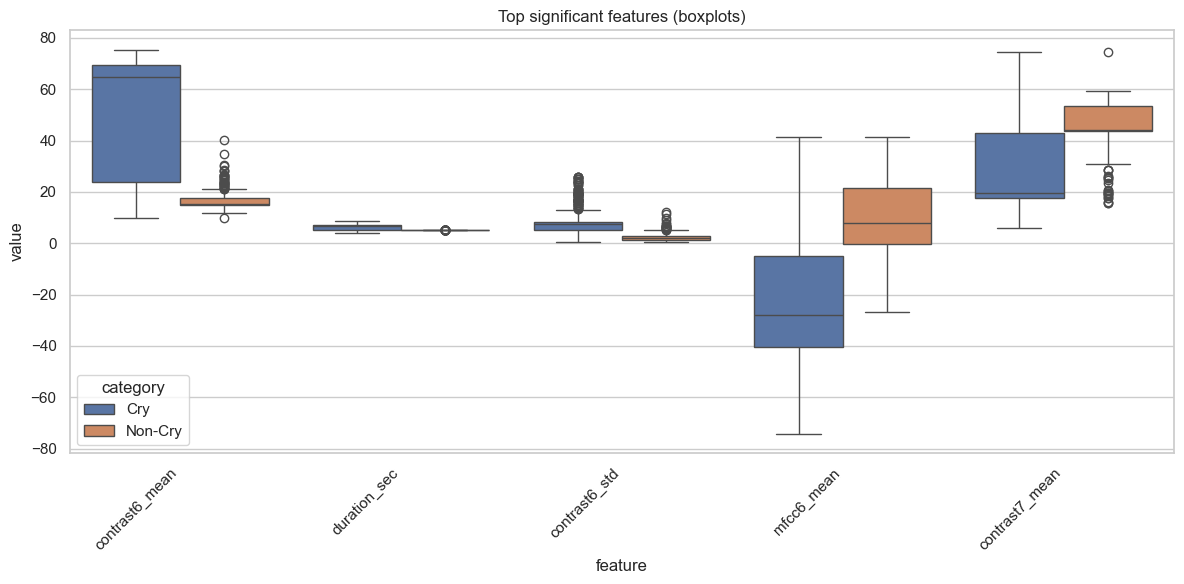

In [20]:
# Welch's t-tests Cry vs Non-Cry with BH correction
from statsmodels.stats.multitest import multipletests

num_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
# Avoid all-NaN columns
num_cols = [c for c in num_cols if features_df[c].notna().sum() > 2]

mask_cry = features_df["category"] == "Cry"
mask_non = features_df["category"] == "Non-Cry"

pvals = []
mean_diff = []
feat_names = []
for c in num_cols:
    x = features_df.loc[mask_cry, c].replace([np.inf, -np.inf], np.nan).dropna()
    yv = features_df.loc[mask_non, c].replace([np.inf, -np.inf], np.nan).dropna()
    if len(x) > 2 and len(yv) > 2:
        stat, p = ttest_ind(x, yv, equal_var=False)
        pvals.append(p)
        mean_diff.append(float(np.nanmean(x) - np.nanmean(yv)))
        feat_names.append(c)

rej, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh') if pvals else ([], [], None, None)

stats_df = pd.DataFrame({
    "feature": feat_names,
    "pval": pvals,
    "qval": qvals if len(qvals) else [],
    "mean_diff": mean_diff,
    "significant": rej if len(rej) else []
}).sort_values(["significant", "qval"], ascending=[False, True])

print("Top significant features (q<0.05):")
if not stats_df.empty:
    display(stats_df[stats_df["significant"]].head(20))
else:
    print("No features tested.")

# One-way ANOVA across Cry subcategories for a few selected features
cry_only = features_df[features_df["category"] == "Cry"].copy()
sel_for_anova = [f for f in ["mfcc1_mean", "zcr_mean", "centroid_mean", "rms_mean"] if f in cry_only.columns]
for ftr in sel_for_anova:
    groups = [g[1][ftr].replace([np.inf, -np.inf], np.nan).dropna().values for g in cry_only.groupby("subcategory")]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) >= 2:
        stat, p = f_oneway(*groups)
        print(f"ANOVA {ftr}: p={p:.3e}")

# Boxplots for top few significant features
top_feats = stats_df[stats_df["significant"]]["feature"].head(5).tolist() if not stats_df.empty else []
if top_feats:
    df_plot = pd.concat([features_df[top_feats], features_df["category"]], axis=1)
    df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna()
    df_plot = df_plot.melt(id_vars=["category"], var_name="feature", value_name="value")
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df_plot, x="feature", y="value", hue="category")
    plt.title("Top significant features (boxplots)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 14. Conclusion and Next Steps

- Summarize key EDA findings: duration ranges, sample rate consistency, feature differences, and separability insights.
- Preparation for modeling: choose standardized format and fixed length, finalize feature set, consider data augmentation (noise, pitch shift, time stretch), and train/test split strategies.

Update this section after reviewing the generated plots and tables.

In [21]:
# 14a. Auto-generated EDA Summary
from IPython.display import Markdown, display

# Duration summary
dur_summary = None
if "duration_sec" in files_df.columns and files_df["duration_sec"].notna().any():
    dur_stats = files_df.groupby("category")["duration_sec"].agg(["count","min","median","max"]).reset_index()
    dur_summary = "\n".join([
        f"- {row['category']}: n={int(row['count'])}, min={row['min']:.2f}s, median={row['median']:.2f}s, max={row['max']:.2f}s"
        for _, row in dur_stats.iterrows()
    ])
else:
    dur_summary = "- Duration stats not available."

# Sample rate summary
sr_summary = "- Sample rate info not available."
if "samplerate" in files_df.columns and files_df["samplerate"].notna().any():
    sr_stats = files_df.dropna(subset=["samplerate"]).groupby("category")["samplerate"].agg([lambda s: sorted(s.unique()), "nunique", "median"]).reset_index()
    parts = []
    for _, row in sr_stats.iterrows():
        uniq = row["<lambda_0>"]
        parts.append(f"- {row['category']}: unique SRs={uniq} (nunique={int(row['nunique'])}), median={row['median']:.0f} Hz")
    sr_summary = "\n".join(parts)

# Significant features from stats_df (t-tests)
sig_summary = "- Statistical tests not run yet."
if 'stats_df' in globals() and isinstance(stats_df, pd.DataFrame) and not stats_df.empty:
    n_sig = int(stats_df[stats_df.get("significant", False)].shape[0])
    top_feats = stats_df.sort_values("qval").head(10)["feature"].tolist() if "qval" in stats_df.columns else []
    sig_summary = f"- Significant features (q<0.05): {n_sig}. Top features: {top_feats}"

# PCA separability
pca_summary = "- PCA not computed yet."
try:
    if 'pca2' in globals():
        ev = float(np.sum(pca2.explained_variance_ratio_))
        pca_summary = f"- PCA 2D explained variance: {ev:.2f} (see PCA plots above)."
    else:
        # Compute quickly if not present
        _num_cols = features_df.select_dtypes(include=[np.number]).columns
        _X = features_df[_num_cols].replace([np.inf, -np.inf], np.nan).fillna(features_df[_num_cols].median(numeric_only=True))
        _X = StandardScaler().fit_transform(_X)
        _p = PCA(n_components=2, random_state=42).fit(_X)
        pca_summary = f"- PCA 2D explained variance: {np.sum(_p.explained_variance_ratio_):.2f}."
except Exception:
    pass

md = f"""
## Auto Summary of Findings

### Duration
{dur_summary}

### Sample Rates
{sr_summary}

### Feature Differences (Cry vs Non-Cry)
{sig_summary}

### Separability Insights
{pca_summary}\n- t-SNE visualization provided above (check scatter plot).
"""

display(Markdown(md))



## Auto Summary of Findings

### Duration
- Cry: n=1450, min=4.15s, median=6.90s, max=8.73s
- Non-Cry: n=324, min=5.00s, median=5.00s, max=5.02s

### Sample Rates
- Cry: unique SRs=[np.float64(8000.0), np.float64(44100.0)] (nunique=2), median=8000 Hz
- Non-Cry: unique SRs=[np.float64(44100.0)] (nunique=1), median=44100 Hz

### Feature Differences (Cry vs Non-Cry)
- Significant features (q<0.05): 72. Top features: ['contrast6_mean', 'duration_sec', 'contrast6_std', 'mfcc6_mean', 'contrast7_mean', 'mfcc12_mean', 'mfcc3_std', 'mfcc9_mean', 'mfcc3_mean', 'contrast4_std']

### Separability Insights
- PCA 2D explained variance: 0.45 (see PCA plots above).
- t-SNE visualization provided above (check scatter plot).


In [22]:
# 14b. Prepare Modeling Plan and Persist Config

# Decide standardization
model_cfg = {
    "target_sr": CONFIG.get("target_sr", 22050),
    "target_format": CONFIG.get("target_format", "wav"),
    "target_duration_sec": CONFIG.get("target_duration_sec", 5.0),
    "mono": True,
    "standardized_root": CONFIG.get("standardized_root"),
}

# Choose features to use: all numeric, but often a curated subset is better
all_numeric = features_df.select_dtypes(include=[np.number]).columns.tolist()
# Example curated list (if present)
curated = [
    "mfcc1_mean", "mfcc2_mean", "mfcc3_mean", "mfcc4_mean", "mfcc5_mean",
    "zcr_mean", "centroid_mean", "bandwidth_mean", "rolloff_mean", "rms_mean",
    "f0_mean"
]
selected_features = [c for c in curated if c in all_numeric]
if not selected_features:
    selected_features = all_numeric  # fallback to all numeric

# Augmentation plan (for training)
augmentation_plan = {
    "noise": {"snr_db": [10, 20]},
    "pitch_shift": {"steps": [-2, -1, 1, 2]},
    "time_stretch": {"rate": [0.9, 1.1]},
    "spec_augment": {"freq_mask_param": 8, "time_mask_param": 16},  # if using spectrogram-based models
}

# Split strategy
split_cfg = {
    "strategy": "stratified_by_category",  # optionally by subcategory
    "train": 0.7, "val": 0.15, "test": 0.15,
    "random_state": 42
}

# Persist modeling config next to notebook
planning = {
    "model_config": model_cfg,
    "selected_features": selected_features,
    "augmentation_plan": augmentation_plan,
    "split": split_cfg,
}

cfg_path = Path("Notebook/modeling_plan.json").resolve()
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(planning, f, indent=2)

print("Saved modeling plan to:", cfg_path)
print("Selected features (count):", len(selected_features))


Saved modeling plan to: C:\Users\mkhan\Documents\Projects\Niha2\Notebook\Notebook\modeling_plan.json
Selected features (count): 11
